In [1]:
# Import models and paths
import numpy as np, pandas as pd, matplotlib.pyplot as plt, joblib, pathlib
from sklearn.model_selection import TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.base import clone

BASE = pathlib.Path.cwd().parents[0]
DATA_PROCESSED = BASE / "data" / "processed"
MODELS = BASE / "models"
REPORTS = BASE / "reports"
REPORTS.mkdir(exist_ok=True)

SYMBOLS = ["QQQ", "VFV.TO", "XEQT.TO"]   # adjust as needed
TRADING_DAYS = 252

In [3]:
# Helper functions for proceeding cells
def load_dataset(symbol: str) -> pd.DataFrame:
    df = pd.read_parquet(DATA_PROCESSED / f"{symbol}_dataset.parquet")
    return df.sort_values("date").reset_index(drop=True)

def tscv_splits(n_samples: int, n_splits: int = 5):
    return list(TimeSeriesSplit(n_splits=n_splits).split(np.arange(n_samples)))

def equity_from_logrets(r: np.ndarray, start: float = 1.0) -> np.ndarray:
    return start * np.exp(np.nancumsum(r))

# stock performance metrics function
def perf_metrics(logrets: pd.Series) -> dict:
    r = logrets.dropna()
    if len(r) == 0:
        return dict(CAGR=np.nan, Vol=np.nan, Sharpe=np.nan, MaxDD=np.nan)
    cagr = r.mean() * TRADING_DAYS
    vol  = r.std(ddof=0) * np.sqrt(TRADING_DAYS)
    sharpe = cagr / vol if vol > 0 else np.nan
    eq = equity_from_logrets(r.values)
    peak = np.maximum.accumulate(eq)
    maxdd = ((eq - peak) / peak).min()
    return dict(CAGR=cagr, Vol=vol, Sharpe=sharpe, MaxDD=maxdd)

In [4]:
# Functions for base and tuned predictor pipelines
def make_X_y(df: pd.DataFrame, task: str):
    feats = df.drop(columns=["date","y_reg","y_cls"])
    X = feats.values.astype(float)
    y = df["y_reg"].values if task=="reg" else df["y_cls"].values
    return X, y, feats.columns.tolist()

def wf_predict_with_pipeline(df: pd.DataFrame, base_pipe: Pipeline, task: str, n_splits: int = 5) -> pd.Series:
    """Clone a (possibly tuned) pipeline and generate OOS preds via TimeSeriesSplit."""
    X, y, feat_names = make_X_y(df, task)
    splits = tscv_splits(len(X), n_splits)
    preds = np.full(len(X), np.nan, dtype=float)

    for tr, te in splits:
        pipe = clone(base_pipe)         # unfitted copy with same hyperparams
        pipe.fit(X[tr], (y if task=="reg" else y)[tr])
        if task == "reg":
            preds[te] = pipe.predict(X[te])
        else:
            # probability of class 1 for classification
            preds[te] = pipe.predict_proba(X[te])[:,1]
    return pd.Series(preds, index=df.index)

# --- Baseline pipelines (same as Day 6) ---
baseline_ridge = Pipeline([("scaler", StandardScaler()), ("ridge", Ridge())])
baseline_hgb   = Pipeline([("hgb", HistGradientBoostingRegressor())])
baseline_logit = Pipeline([("scaler", StandardScaler()),
                           ("logit", LogisticRegression(max_iter=200, class_weight="balanced"))])

# --- Tuned pipelines (loaded, then cloned per fold) ---
def load_tuned(symbol: str, kind: str) -> Pipeline:
    """
    kind in {"ridge_reg_tuned", "hgb_reg_tuned", "logit_cls_tuned"}
    """
    b = joblib.load(MODELS / f"{symbol}_{kind}.pkl")
    return b["model"]  # already a Pipeline with best params (we'll clone inside folds)

In [5]:
# Function for simulating long cash strategy
def run_long_cash_strategy(
    df: pd.DataFrame,
    signal: pd.Series,
    kind: str = "reg",         # "reg" or "cls"
    reg_thr: float = 0.0,      # go long if pred > thr
    cls_thr: float = 0.55,     # go long if prob > thr
    cost_bps: float = 0.0005
) -> pd.DataFrame:
    out = pd.DataFrame(index=df.index)
    out["date"] = df["date"]
    out["y_reg"] = df["y_reg"]

    pos = (signal > (reg_thr if kind=="reg" else cls_thr)).astype(int)
    trades = pos.diff().abs().fillna(0.0)
    costs = cost_bps * trades

    out["pos"] = pos
    out["costs"] = costs
    out["r_strategy"] = pos * out["y_reg"] - costs
    out["r_bh"] = out["y_reg"]
    out["equity_strategy"] = equity_from_logrets(out["r_strategy"].values)
    out["equity_bh"] = equity_from_logrets(out["r_bh"].values)
    return out

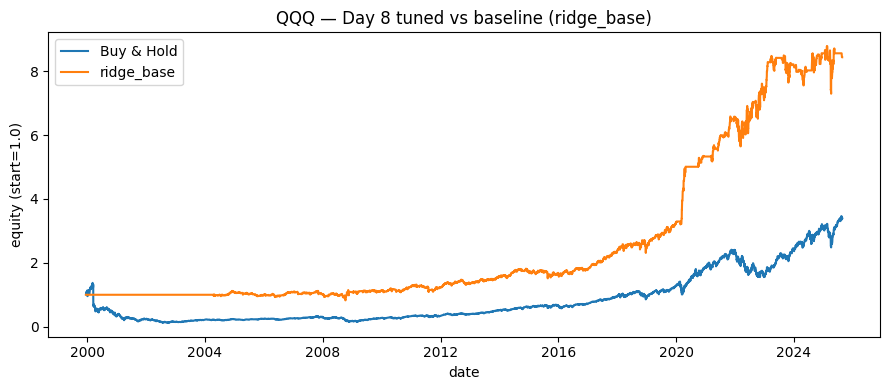

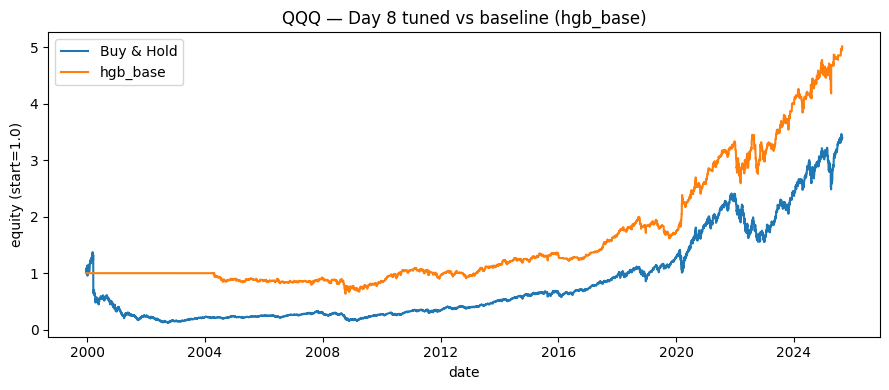

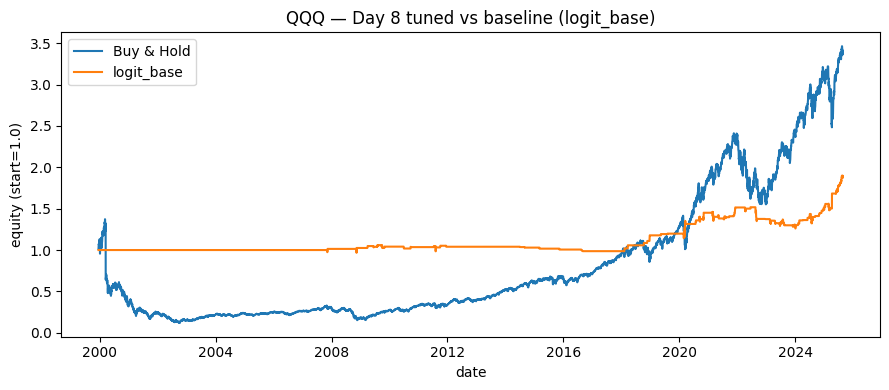

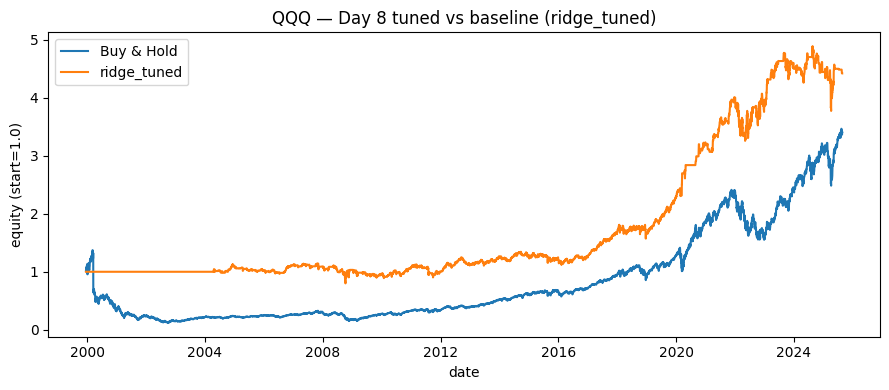

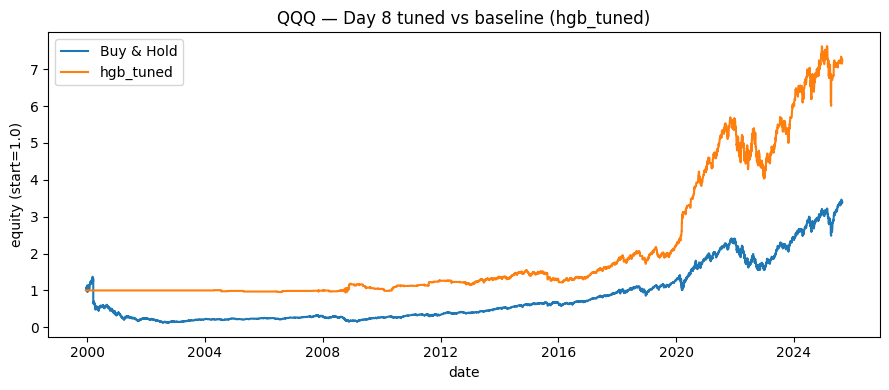

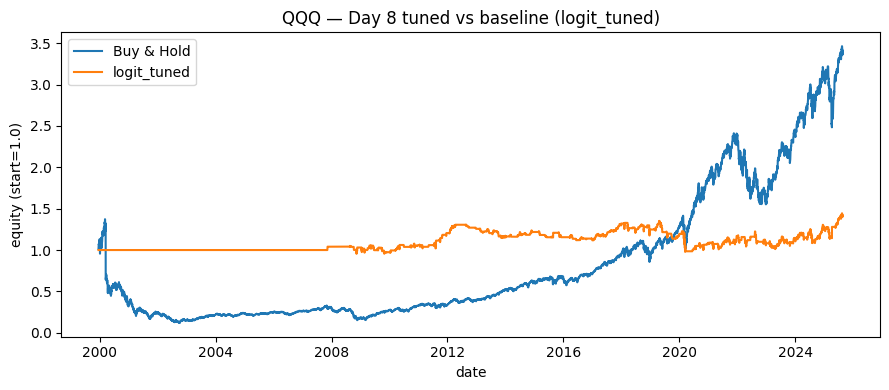

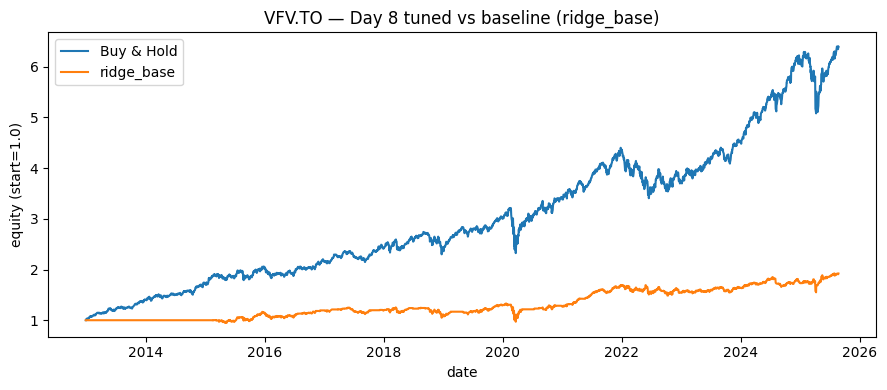

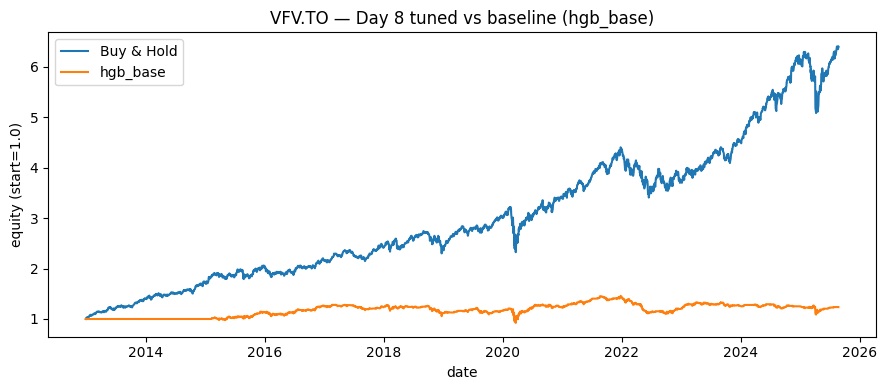

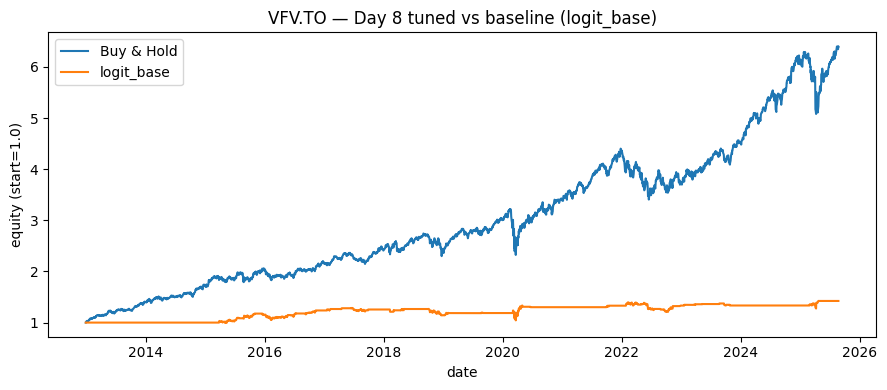

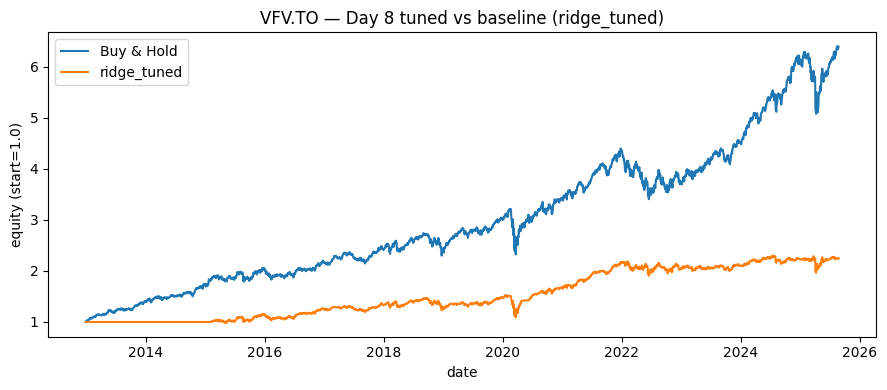

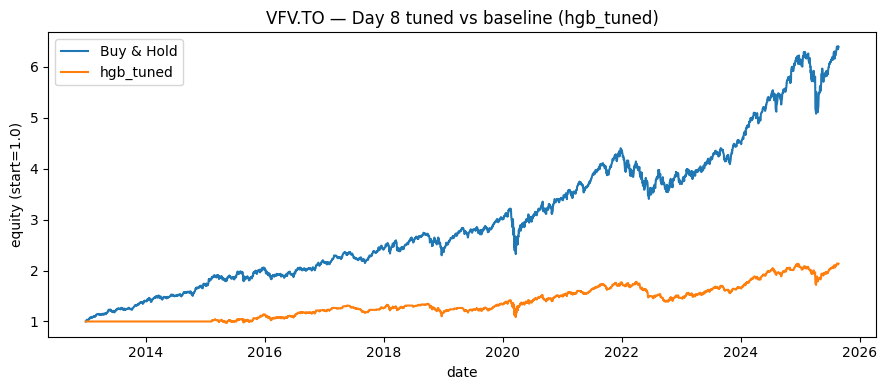

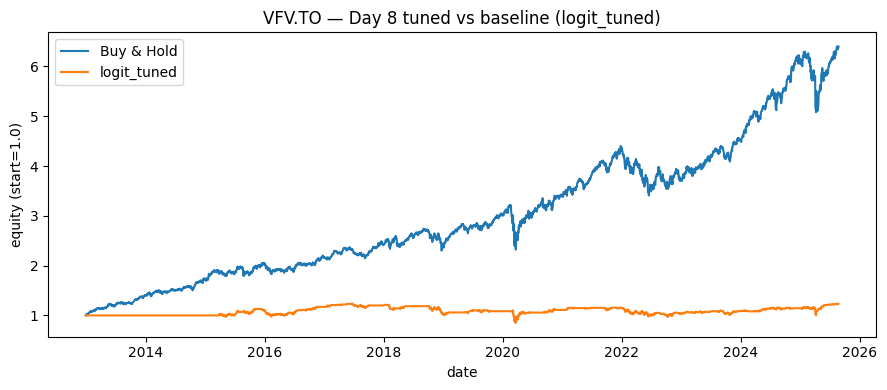

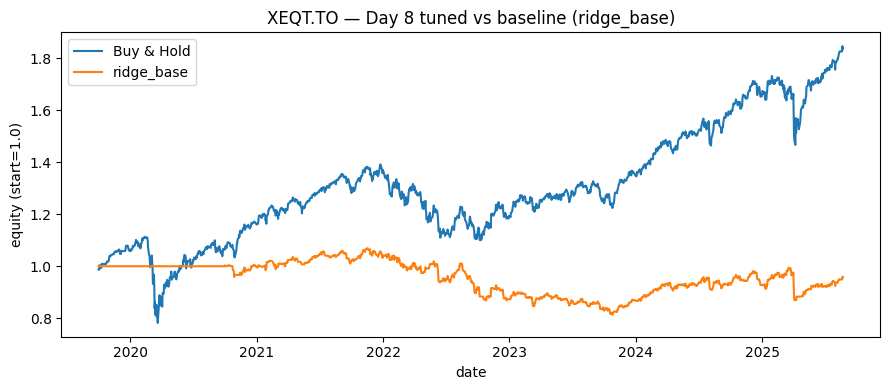

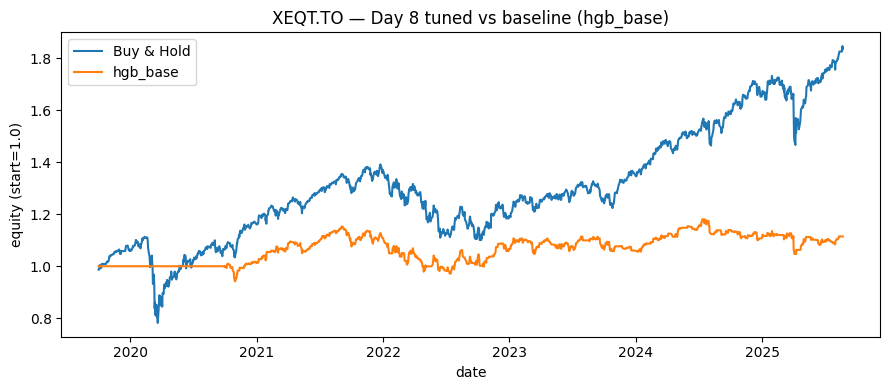

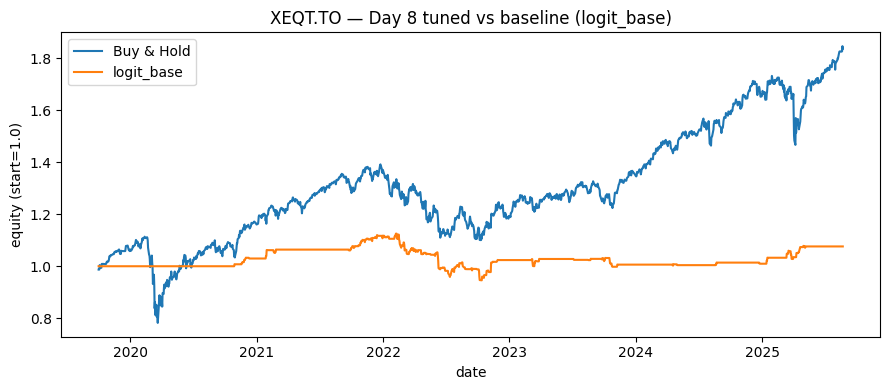

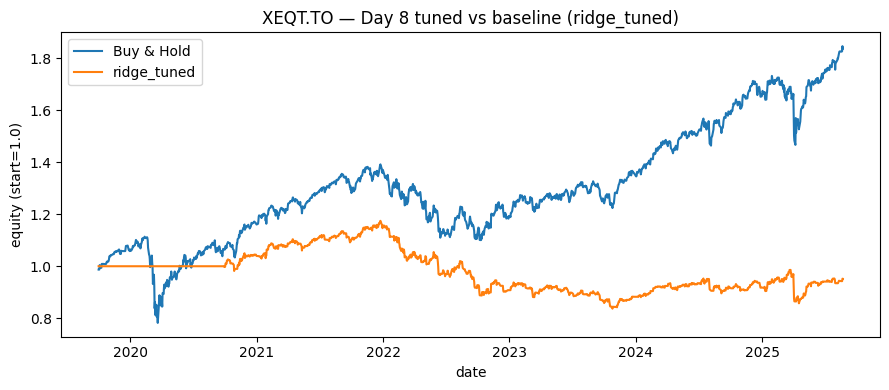

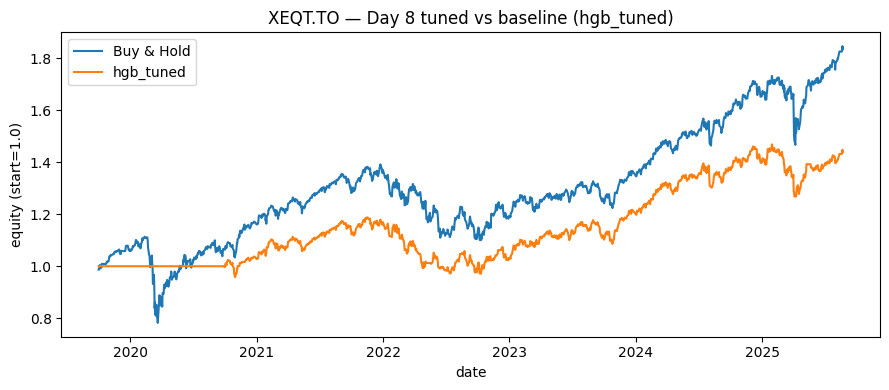

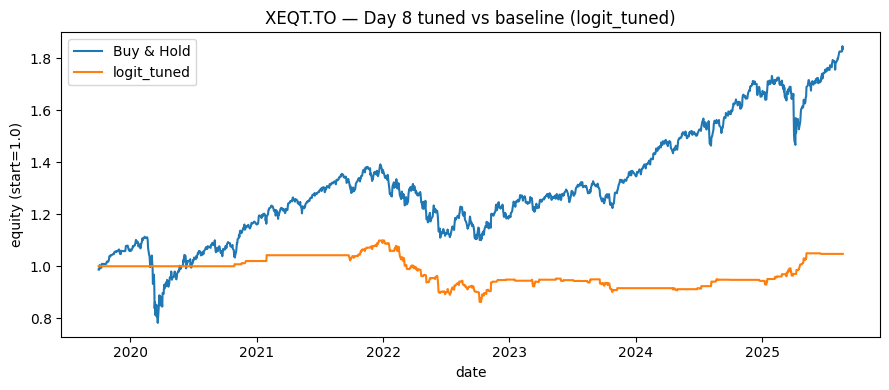

,symbol,model,CAGR,Vol,Sharpe,MaxDD,BH_CAGR,BH_Sharpe,BH_MaxDD
1,QQQ,hgb_base,0.062821,0.131350,0.478274,-0.368049,0.047788,0.156498,-0.912783
4,QQQ,hgb_tuned,0.077235,0.132128,0.584545,-0.292141,0.047788,0.156498,-0.912783
2,QQQ,logit_base,0.024891,0.066434,0.374669,-0.169681,0.047788,0.156498,-0.912783
5,QQQ,logit_tuned,0.013655,0.104943,0.130122,-0.275939,0.047788,0.156498,-0.912783
0,QQQ,ridge_base,0.083201,0.139011,0.598523,-0.264914,0.047788,0.156498,-0.912783
3,QQQ,ridge_tuned,0.057948,0.134925,0.429486,-0.298795,0.047788,0.156498,-0.912783
7,VFV.TO,hgb_base,0.016834,0.126469,0.133104,-0.279999,0.147242,0.925384,-0.277178
10,VFV.TO,hgb_tuned,0.060224,0.135069,0.445871,-0.232641,0.147242,0.925384,-0.277178
8,VFV.TO,logit_base,0.028000,0.099249,0.282123,-0.188098,0.147242,0.925384,-0.277178
11,VFV.TO,logit_tuned,0.016898,0.120323,0.140437,-0.312605,0.147242,0.925384,-0.277178


Saved: /Users/itzronald/Desktop/trend-predictor/reports/day8_backtest_metrics.csv


In [6]:
# Backtesting baseline and tuned models
def backtest_baseline_vs_tuned(symbol: str, n_splits=5, reg_thr=0.0, cls_thr=0.55, cost_bps=0.0005):
    df = load_dataset(symbol)

    # --- Walk-forward predictions (baseline) ---
    yhat_ridge_base = wf_predict_with_pipeline(df, baseline_ridge, task="reg", n_splits=n_splits)
    yhat_hgb_base   = wf_predict_with_pipeline(df, baseline_hgb,   task="reg", n_splits=n_splits)
    proba_log_base  = wf_predict_with_pipeline(df, baseline_logit, task="cls", n_splits=n_splits)

    # --- Walk-forward predictions (tuned) ---
    ridge_tuned = load_tuned(symbol, "ridge_reg_tuned")
    hgb_tuned   = load_tuned(symbol, "hgb_reg_tuned")
    logit_tuned = load_tuned(symbol, "logit_cls_tuned")

    yhat_ridge_tuned = wf_predict_with_pipeline(df, ridge_tuned, task="reg", n_splits=n_splits)
    yhat_hgb_tuned   = wf_predict_with_pipeline(df, hgb_tuned,   task="reg", n_splits=n_splits)
    proba_log_tuned  = wf_predict_with_pipeline(df, logit_tuned, task="cls", n_splits=n_splits)

    # --- Run strategies ---
    runs = {
        "ridge_base": run_long_cash_strategy(df, yhat_ridge_base, "reg", reg_thr, cost_bps=cost_bps),
        "hgb_base":   run_long_cash_strategy(df, yhat_hgb_base,   "reg", reg_thr, cost_bps=cost_bps),
        "logit_base": run_long_cash_strategy(df, proba_log_base,  "cls", cls_thr, cost_bps=cost_bps),
        "ridge_tuned":run_long_cash_strategy(df, yhat_ridge_tuned,"reg", reg_thr, cost_bps=cost_bps),
        "hgb_tuned":  run_long_cash_strategy(df, yhat_hgb_tuned,  "reg", reg_thr, cost_bps=cost_bps),
        "logit_tuned":run_long_cash_strategy(df, proba_log_tuned, "cls", cls_thr, cost_bps=cost_bps),
    }

    # --- Metrics & plots ---
    rows = []
    for name, bt in runs.items():
        m = perf_metrics(bt["r_strategy"])
        m_bh = perf_metrics(bt["r_bh"])
        rows.append(dict(symbol=symbol, model=name, **m,
                         BH_CAGR=m_bh["CAGR"], BH_Sharpe=m_bh["Sharpe"], BH_MaxDD=m_bh["MaxDD"]))

        # Equity plot
        plt.figure(figsize=(9,4))
        plt.plot(bt["date"], bt["equity_bh"], label="Buy & Hold")
        plt.plot(bt["date"], bt["equity_strategy"], label=name)
        plt.title(f"{symbol} — Day 8 tuned vs baseline ({name})")
        plt.xlabel("date"); plt.ylabel("equity (start=1.0)")
        plt.legend()
        plt.tight_layout()
        out_png = REPORTS / f"day8_{symbol}_{name}_equity.png"
        plt.savefig(out_png, dpi=150)
        plt.show()

        # Save timeseries
        bt.to_csv(REPORTS / f"day8_{symbol}_{name}_bt.csv", index=False)

    return pd.DataFrame(rows)

all_rows = []
for sym in SYMBOLS:
    res = backtest_baseline_vs_tuned(sym, n_splits=5, reg_thr=0.0, cls_thr=0.55, cost_bps=0.0005)
    all_rows.append(res)

day8_metrics = pd.concat(all_rows, ignore_index=True)
day8_csv = REPORTS / "day8_backtest_metrics.csv"
day8_metrics.to_csv(day8_csv, index=False)
display(day8_metrics.sort_values(["symbol","model"]))
print("Saved:", day8_csv)

In [7]:
# Short comparison table for tuned versus baseline models
def compact_compare(df: pd.DataFrame):
    # Keep only CAGR/Sharpe for a quick glance
    keep = df[["symbol","model","CAGR","Sharpe","MaxDD","BH_CAGR","BH_Sharpe"]].copy()
    # add a “delta vs BH” column
    keep["CAGR_vs_BH"] = keep["CAGR"] - keep["BH_CAGR"]
    keep["Sharpe_vs_BH"] = keep["Sharpe"] - keep["BH_Sharpe"]
    return keep.sort_values(["symbol","model"])

display(compact_compare(day8_metrics))

,symbol,model,CAGR,Sharpe,MaxDD,BH_CAGR,BH_Sharpe,CAGR_vs_BH,Sharpe_vs_BH
1,QQQ,hgb_base,0.062821,0.478274,-0.368049,0.047788,0.156498,0.015033,0.321775
4,QQQ,hgb_tuned,0.077235,0.584545,-0.292141,0.047788,0.156498,0.029446,0.428046
2,QQQ,logit_base,0.024891,0.374669,-0.169681,0.047788,0.156498,-0.022897,0.218171
5,QQQ,logit_tuned,0.013655,0.130122,-0.275939,0.047788,0.156498,-0.034133,-0.026376
0,QQQ,ridge_base,0.083201,0.598523,-0.264914,0.047788,0.156498,0.035413,0.442025
3,QQQ,ridge_tuned,0.057948,0.429486,-0.298795,0.047788,0.156498,0.010160,0.272987
7,VFV.TO,hgb_base,0.016834,0.133104,-0.279999,0.147242,0.925384,-0.130409,-0.792280
10,VFV.TO,hgb_tuned,0.060224,0.445871,-0.232641,0.147242,0.925384,-0.087019,-0.479513
8,VFV.TO,logit_base,0.028000,0.282123,-0.188098,0.147242,0.925384,-0.119242,-0.643261
11,VFV.TO,logit_tuned,0.016898,0.140437,-0.312605,0.147242,0.925384,-0.130344,-0.784947
